<a href="https://colab.research.google.com/github/hhhhhhhhhhhhhhhhho/AI_Hakcing/blob/master/Laboratory/%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%A0%81%EB%8C%80%EC%A0%81_%EA%B3%B5%EA%B2%A9_%EB%B0%A9%EC%96%B4_%EA%B8%B0%EB%B2%95%EC%97%90_%EA%B4%80%ED%95%9C_%EC%97%B0%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0  22783      0 --:--:-- --:--:-- --:--:-- 22783


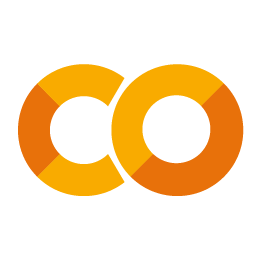

In [ ]:
from google.colab.patches import cv2_imshow
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D,Conv3D, MaxPooling2D, Dropout, Flatten, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import os
import numpy
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

from keras.callbacks import TensorBoard


* 인용  
Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction 저자 Jonathan Masci



### Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tae6eong","key":"36ea15ca836d181bfc598f8231eaad80"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [ ]:
!kaggle competitions download -c imagenet-object-localization-challenge

  0% 0.00/980k [00:00<?, ?B/s]
100% 980k/980k [00:00<00:00, 68.3MB/s]
  0% 0.00/6.07M [00:00<?, ?B/s]
100% 6.07M/6.07M [00:00<00:00, 96.0MB/s]
  0% 0.00/30.9k [00:00<?, ?B/s]
100% 30.9k/30.9k [00:00<00:00, 32.0MB/s]
  0% 0.00/245k [00:00<?, ?B/s]
100% 245k/245k [00:00<00:00, 86.1MB/s]
  6% 8.62G/155G [03:19<56:24, 46.3MB/s]  
User cancelled operation


In [ ]:
!unzip /content/imagenet_object_localization_patched2019.tar.gz

Archive:  /content/imagenet_object_localization_patched2019.tar.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/imagenet_object_localization_patched2019.tar.gz or
        /content/imagenet_object_localization_patched2019.tar.gz.zip, and cannot find /content/imagenet_object_localization_patched2019.tar.gz.ZIP, period.


### KISA 대충 이미지 데이터

In [ ]:
!curl -O https://kr.object.ncloudstorage.com/aidata-sample/20-02/2020-02-119.상품이미지_sample.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   308  100   308    0     0    135      0  0:00:02  0:00:02 --:--:--   135


### 데이터 불러오기 및 분할

In [ ]:
from tensorflow.keras import datasets

cifar_mnist = datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar_mnist.load_data()

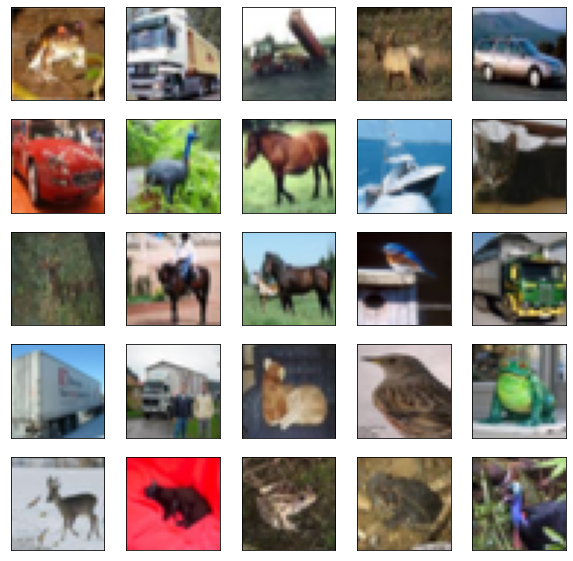

In [ ]:
class_names = [
               'Airplane',
               'Car',
               'Birs',
               'Cat',
               'Deer',
               'Dog',
               'Frog',
               'Horse',
               'Ship',
               'Truck'
]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)

plt.show()

### 데이터 전처리 
1. 정규화
2. 노이즈 추가 


In [ ]:
import numpy as np
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array

def solo_preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (1,32, 32, 3))
    return array

def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
X_train = train_images 
X_test = test_images

In [ ]:
noised_X_train = noise(X_train)
noised_X_test = noise(X_test)

In [ ]:
X_train = preprocess(X_train)
nosied_X_train = preprocess(noised_X_train)
X_test = preprocess(X_test)
noised_X_test = preprocess(X_test)

In [ ]:
X_train.shape

(50000, 32, 32, 3)

## keras CNN AutoEncoder Model

In [ ]:
import keras
import tensorboard

# Encoder 
with tf.device('/gpu:0'): 
  input = layers.Input(shape=(32, 32, 3))

  # Encoder
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)

  # Decoder
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

  # Autoencoder
  autoencoder = Model(input, x)
  autoencoder.compile(optimizer="adam", loss="mse")
  autoencoder.summary()


history=autoencoder.fit(
    x=noised_X_train,
    y=X_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noised_X_test, X_test)
)

'''
  model.input_shape(shape(32,32,3))
  model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  #model.add(Dropout(0.25))
  
  model.add(Conv2DTranspose(32, (3, 3),strides=2, activation='relu'))
  #model.add(Dropout(0.5))
  model.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu'))
  

  model.add(Conv2D(1,(3,3),activation="sigmoid"))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()
'''

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        9248  

'\n  model.input_shape(shape(32,32,3))\n  model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation=\'relu\'))\n  model.add(MaxPooling2D((2,2)))\n  model.add(Conv2D(32, (3, 3), activation=\'relu\'))\n  model.add(MaxPooling2D((2,2)))\n  #model.add(Dropout(0.25))\n  \n  model.add(Conv2DTranspose(32, (3, 3),strides=2, activation=\'relu\'))\n  #model.add(Dropout(0.5))\n  model.add(Conv2DTranspose(32, (3, 3), strides=2, activation=\'relu\'))\n  \n\n  model.add(Conv2D(1,(3,3),activation="sigmoid"))\n\n  model.compile(loss=\'categorical_crossentropy\',\n                optimizer=\'adam\',\n                metrics=[\'accuracy\'])\n\nmodel.summary()\n'

In [58]:
autoencoder.save('best CAE model.h5')

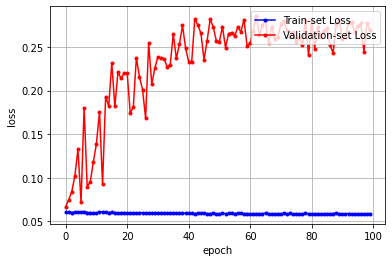

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 검증

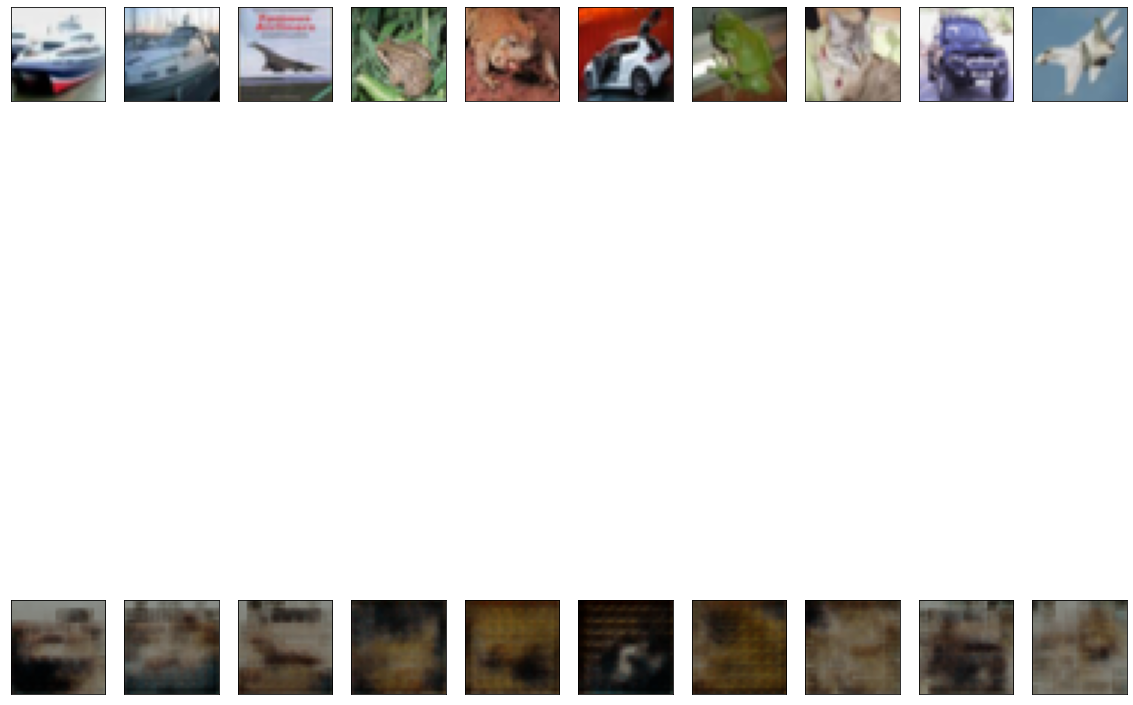

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 20))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    
    decoded_imgs[i]*=255
  
    plt.imshow(decoded_imgs[i].astype("uint8"))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 이미지로 뽑아보기 

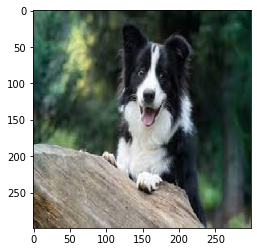

In [52]:
import numpy as np
from PIL import Image

img = Image.open("/content/Unknown-2.png")
plt.imshow(img)

In [53]:
resized_image = img.resize((32, 32))
imgArray = np.array(resized_image)

imgArray.shape

(32, 32, 3)

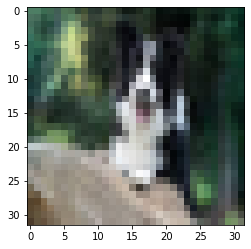

In [54]:
plt.imshow(resized_image)

In [55]:
imgArray=imgArray.reshape(1,32,32,3)
result = autoencoder.predict(imgArray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


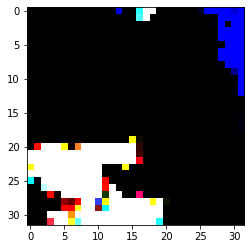

In [57]:
type(result)
result*=255
result.astype("uint8")
result = result.reshape(32,32,3)
plt.imshow(result)